**Transformer from Scratch**


---
Transformer to translate English to one of Indian languages - Hindi



In [ ]:
# Install datasets
!pip install datasets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import regex as re
import tensorflow as tf

import math
import pickle
import time
import unicodedata

from datasets import load_dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout, Dense, Embedding, Layer, LayerNormalization
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Mean

In [ ]:
# Download English-Hindi dataset
# Source: https://www.cfilt.iitb.ac.in/iitb_parallel/

dataset = load_dataset('cfilt/iitb-english-hindi')

In [ ]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['translation'],
        num_rows: 520
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2507
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1659083
    })
})

In [ ]:
print("A random observation...\n")
dataset['train'][13000]

A random observation...



{'translation': {'en': 'Choose file or directory to remove:',
  'hi': 'फ़ाइल या निर्देशिका को हटाने के लिए चुनेंः'}}

In [ ]:
# Prepare dataset
train_dataset = dataset['train'][:10000]['translation']
validation_dataset = dataset['validation']['translation']
test_dataset = dataset['test']['translation']

print('Train dataset size: {}'.format(len(train_dataset)))
print('Train dataset size: {}'.format(len(validation_dataset)))
print('Train dataset size: {}'.format(len(test_dataset)))

Train dataset size: 10000
Train dataset size: 520
Train dataset size: 2507


In [ ]:
src_dataset = np.array([])  # Source Language: English
tgt_dataset = np.array([])  # Target Languange: Hindi

for pair in train_dataset:
    src_dataset = np.append(src_dataset, pair['en'])
    tgt_dataset = np.append(tgt_dataset, pair['hi'])

src_dataset[0], tgt_dataset[0]

('Give your application an accessibility workout',
 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें')

In [ ]:
# Convert the source (English) text to lowercase
src_dataset = np.char.lower(src_dataset)
src_dataset[0]

'give your application an accessibility workout'

In [ ]:
# Remove special characters in both source dataset and target dataset
def clean_text(text):
  # Retain punctuations ^ a-z0-9.?!,:/- so as to not alter/loose the meaning of text
  # Add a whitespace before and after the punctuations
  text = re.sub('([.?!,:/-])', r' \1 ', text)

  # Remove additional whitespace
  text = text.strip()

  return text

# Source dataset (English)
for idx in range(len(src_dataset)):
  src_dataset[idx] = clean_text(src_dataset[idx])

# Target dataset (Hindi)
for idx in range(len(tgt_dataset)):
  tgt_dataset[idx] = clean_text(tgt_dataset[idx])

In [ ]:
src_dataset[8], tgt_dataset[8]

('the color and opacity of the highlight border .',
 'हाइलाइट किए गए सीमांत का रंग और अपारदर्शिता।')

In [ ]:
# Tokenize the source and target text
def tokenize_text(_dataset):
  tknzr = Tokenizer()
  tknzr.fit_on_texts(_dataset)
  _tokenized = tknzr.texts_to_sequences(_dataset)
  _word_to_idx = tknzr.word_index
  return tknzr, _tokenized, _word_to_idx

src_tknzr, src_sequences, src_vocabulary = tokenize_text(src_dataset)
src_max_sequence_length = max(len(sequence) for sequence in src_sequences)
print("Maximum length of sequence in English (source): %s" % src_max_sequence_length)

tgt_tknzr, tgt_sequences, tgt_vocabulary = tokenize_text(tgt_dataset)
tgt_max_sequence_length = max(len(sequence) for sequence in tgt_sequences)
print("Maximum length of sequence in Hindi (target): %s" % tgt_max_sequence_length)

Maximum length of sequence in English (source): 41
Maximum length of sequence in Hindi (target): 40


In [ ]:
src_vocabulary_size = len(src_vocabulary)
print("Number of unique words in English (source) language: %s" % src_vocabulary_size)

tgt_vocabulary_size = len(tgt_vocabulary)
print("Number of unique words in Hindi (target) language: %s" % tgt_vocabulary_size)

Number of unique words in English (source) language: 1558
Number of unique words in Hindi (target) language: 2037


In [ ]:
src_sequences[10], tgt_sequences[10]

([1, 67, 45, 314, 2, 1, 57, 115], [71, 94, 100, 207, 1, 69, 50, 650])

In [ ]:
# Prepend and append the sequences with [START] and [END], respectively
# [START]: vocabulary_size + 1
# [END]: vocabulary_size + 2
def add_start_end_tokens(sequence, vocabulary_size):
    sequence = [vocabulary_size+1] + sequence + [vocabulary_size+2]
    return sequence

In [ ]:
# Source sequences
for s_idx in range(len(src_sequences)):
  src_sequences[s_idx] = add_start_end_tokens(src_sequences[s_idx], src_vocabulary_size)

# Target sequences
for t_idx in range(len(tgt_sequences)):
  tgt_sequences[t_idx] = add_start_end_tokens(tgt_sequences[t_idx], tgt_vocabulary_size)

In [ ]:
src_sequences[10], tgt_sequences[10]

([1559, 1, 67, 45, 314, 2, 1, 57, 115, 1560],
 [2038, 71, 94, 100, 207, 1, 69, 50, 650, 2039])

In [ ]:
# Pad the sequences to src_max_sequence_length (source) & tgt_max_sequence_length (target)
src_padded_sequences = pad_sequences(src_sequences, 
                                     maxlen=src_max_sequence_length, 
                                     padding='post',
                                     truncating='post')
print("Source (English):")
print("-"*17)
print(src_padded_sequences.shape)
print(src_padded_sequences[10])

print()

tgt_padded_sequences = pad_sequences(tgt_sequences, 
                                     maxlen=tgt_max_sequence_length,
                                     padding='post',
                                     truncating='post')
print("Target (Hindi):")
print("-"*17)
print(tgt_padded_sequences.shape)
print(tgt_padded_sequences[10])

Source (English):
-----------------
(10000, 41)
[1559    1   67   45  314    2    1   57  115 1560    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]

Target (Hindi):
-----------------
(10000, 40)
[2038   71   94  100  207    1   69   50  650 2039    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
# Global variables
D_MODEL = 512
BATCH_SIZE = 64
BUFFER_SIZE = 20000 
h = 8 # h: attention layers or heads
p_dropout = 0.1 # rate

**Positional Encoding [3]**



In [ ]:
# The maximum length of sequence is 41 (max(src_max_sequence_length, tgt_max_sequence_length))
# In this case, the positional encoding is computed for 100 positions
p_encoding = np.ndarray((1, 100, D_MODEL)) # shape: 1x100x512 (100 positions x D_MODEL dimensions)

for pos in range(100):
    p_vector = []
    for idx in range(D_MODEL):
        x = pos / 10000 ** (2 * idx / D_MODEL)
        if idx % 2 == 0: 
            p_vector.append(np.sin(x))  # even positions
        else:
            p_vector.append(np.cos(x))  # odd positions
    p_encoding[0][pos] = np.array(p_vector)

p_encoding = tf.convert_to_tensor(p_encoding, dtype='float32')

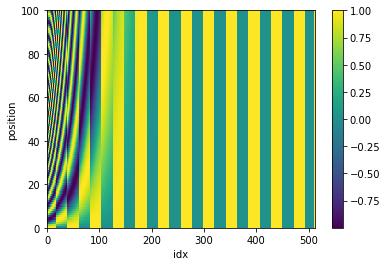

In [ ]:
# Plot positional encodings
plt.pcolormesh(p_encoding[0])
plt.xlabel('idx')
plt.ylabel('position')
plt.colorbar()

In [ ]:
class TransformerInput(Layer):
  def __init__(self, vocabulary_size):
    super().__init__()

    # Embedding layer
    self.embedding = Embedding(vocabulary_size, D_MODEL) 

    # Dropout layer
    self.dropout = Dropout(p_dropout)
    
  def call(self, padded_sequences, training):
    # Input (padded_sequences): BATCH_SIZE x sequence length
    # 64x39 - Source (English) & Target (Hindi)
    # Output (t_input): BATCH_SIZE x sequence length x D_MODEL 
    # 64x39x512 - Source (English) & Target (Hindi)
    t_input = self.embedding(padded_sequences)

    # Add positional encoding to embeddings
    # Positional encoding (p_encoding): 1x39x512 - Source (English) & Target (Hindi)
    sequence_length = padded_sequences.shape[1] # Positions -> 0 to sequence_length - 1
    t_input = tf.add(t_input, p_encoding[:, :sequence_length, :])

    # Apply dropout
    t_input = self.dropout(t_input, training)

    # Output (t_input): BATCH_SIZE x sequence length x D_MODEL 
    # 64x39x512 - Source (English) & Target (Hindi)
    return t_input

In [ ]:
class LinearLayer(Layer):
  def __init__(self, d_k):
    super().__init__()

    # Input to each encoder layer passes through Dense layers to generate Query (Q), Key (K) & Value (V) tensors 
    # Each Dense layer has (d_k/d_v)xh number of linear (f(x)=x) activation units
    # because it's more efficient than h Dense layers in a loop with d_k/d_v linear activation units in each
    # h (attention layers or heads) = 8
    # d_k/d_v = 64
    self.d_k = self.d_v = d_k

    self.q_linear = Dense(D_MODEL)  # units = D_MODEL: 64x8 (d_kxh)
    self.k_linear = Dense(D_MODEL)  # units = D_MODEL: 64x8 (d_kxh)
    self.v_linear = Dense(D_MODEL)  # units = D_MODEL: 64x8 (d_vxh)

  def call(self, q_input, k_input, v_input):
    # Input (q_input, k_input, v_input): BATCH_SIZE x sequence length x D_MODEL 
    # Output (q, k, v): BATCH_SIZE x sequence length x D_MODEL 
    # 64x39x512 - Source (English) & Target (Hindi)
    q = self.q_linear(q_input) 
    k = self.k_linear(k_input)
    v = self.v_linear(v_input)

    # Reshape q, k, v from (BATCH_SIZE x sequence length x D_MODEL) to (BATCH_SIZE x h x sequence length x d_k/d_v)
    # 64x8x39x64 - Source (English) & Target (Hindi)
    # -1 for sequence length (39 - Source (English) & Target (Hindi))
    q = tf.transpose(tf.reshape(q, shape=(BATCH_SIZE, -1, h, self.d_k)), perm=(0, 2, 1, 3))
    k = tf.transpose(tf.reshape(k, shape=(BATCH_SIZE, -1, h, self.d_k)), perm=(0, 2, 1, 3)) 
    v = tf.transpose(tf.reshape(v, shape=(BATCH_SIZE, -1, h, self.d_v)), perm=(0, 2, 1, 3)) 

    return q, k, v

In [ ]:
class ScaledDotProductAttention(Layer):
  def __init__(self, d_k):
    super().__init__()

    # d_k/d_v = 64
    self.d_k = d_k
    
  def call(self, q, k, v, mask):
    # Input (q, k): BATCH_SIZE x h x sequence length x d_k/d_v 
    # 64x8x39x64 - Source (English) & Target (Hindi)
    # Output (attention_weights): BATCH_SIZE x h x sequence length x sequence length
    # Source (English) & Target (Hindi): q.k_T = (64x8x39x64).(64x8x64x39) = (64x8x39x39)
    attention_weights = tf.matmul(q, k, transpose_b=True)

    # Scale attention_weights by sqrt(d_k)
    scaled_attention_weights = tf.divide(attention_weights, 
                                         tf.sqrt(tf.cast(self.d_k, dtype='float32')))

    if mask is not None:
      # Input, Output (mask): 
      # padding_mask - BATCH_SIZE x 1 x 1 x sequence length 
      # 64x1x1x39 - Source (English)
      # look_ahead_mask - 1 x 1 x sequence length x sequence length
      # 1x1x39x39 - Target (Hindi)
      mask = mask * -1e25
      scaled_attention_weights = tf.add(scaled_attention_weights, mask)

    # Apply softmax on attention_weights
    attention_weights = tf.nn.softmax(scaled_attention_weights)

    # Input (attention_weights, v): BATCH_SIZE x h x sequence length x sequence length
    # 64x8x39x39 - Source (English) & Target (Hindi)
    # Output (attention_output): 
    # Source (English) & Target (Hindi): attention_weights.v = (64x8x39x39).(64x8x39x64) = (64x8x39x64)
    attention_output = tf.matmul(attention_weights, v)

    return attention_output

In [ ]:
class MultiHeadAttention(Layer):
  def __init__(self, d_k):
    super().__init__()

    # d_k/d_v = 64
    self.d_k = d_k

    # Scaled dot-product attention
    self.sdpa = ScaledDotProductAttention(self.d_k)

    # The outputs of all attention heads are concatenated and passed through a Dense layer 
    # The Dense layer has D_MODEL number of linear (f(x)=x) activation units
    self.z_linear = Dense(D_MODEL)

  def call(self, q, k, v, mask=None):
    # Input (q, k, v): BATCH_SIZE x h x sequence length x d_k/d_v
    # Output (attention_output): BATCH_SIZE x h x sequence length x d_k/d_v
    # 64x8x39x64 - Source (English) & Target (Hindi)
    attention_output = self.sdpa(q, k, v, mask)

    # Reshape attention_output from BATCH_SIZE x h x sequence length x d_k/d_v to BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - Source (English) & Target (Hindi)
    attention_output = tf.reshape(tf.transpose(attention_output, perm=(0, 2, 1, 3)), shape=(BATCH_SIZE, -1, D_MODEL))

    # Output (mha_output): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - Source (English) & Target (Hindi)
    mha_output = self.z_linear(attention_output)

    return mha_output

In [ ]:
class AddNorm(Layer):
  def __init__(self):
    super().__init__()

    # Layer normalization of x + sublayer(x)
    self.l_normalization = LayerNormalization()

  def call(self, x, sublayer_x):
    # Input (x, sublayer_x): BATCH_SIZE x sequence length x D_MODEL
    # Output(_sum): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - Source (English) & Target (Hindi)
    _sum = tf.add(x, sublayer_x)

    # Output(an_output): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - Source (English) & Target (Hindi)
    an_output = self.l_normalization(_sum)

    return(an_output)

In [ ]:
class FeedForward(Layer):
  def __init__(self):
    super().__init__()

    # The first Dense layer has 2048 'relu' activation units
    self.d_ff = 2048
    self.ff_1 = Dense(self.d_ff, activation='relu')

    # The second Dense layer has D_MODEL linear activation units
    self.ff_2 = Dense(D_MODEL)

  def call(self, ff_input):
    # Input (ff_input): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - Source (English) & Target (Hindi)
    # Output (ff_1_output): BATCH_SIZE x sequence length x d_ff
    # 64x39x2048 - Source (English) & Target (Hindi)
    ff_1_output = self.ff_1(ff_input)

    # Output (ff_output): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - Source (English) & Target (Hindi)
    ff_output = self.ff_2(ff_1_output)

    return ff_output

In [ ]:
class EncoderLayer(Layer):
  def __init__(self, d_k):
    super().__init__()

    # d_k/d_v = 64
    self.d_k = d_k

    # Linear layer
    self.l_layer = LinearLayer(self.d_k)

    # Multi-head attention
    self.mha = MultiHeadAttention(self.d_k)

    # Dropout layers
    self.dropout_1 = Dropout(p_dropout)
    self.dropout_2 = Dropout(p_dropout)

    # Add x & sublayer(x). Apply layer normalization on the sum
    self.an_1 = AddNorm()
    self.an_2 = AddNorm()

    # Feed forward layer
    self.ff = FeedForward()

  def call(self, encoder_input, padding_mask, training):
    # Input (encoder_input): BATCH_SIZE x sequence length x D_MODEL 
    # 64x39x512 - English
    # Output (q, k, v): BATCH_SIZE x h x sequence length x d_k/d_v 
    # 64x8x39x64 - English
    q, k, v = self.l_layer(encoder_input, encoder_input, encoder_input)
      
    # Output (mha_output): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - English
    mha_output = self.mha(q, k, v, padding_mask)

    # Apply dropout
    mha_output = self.dropout_1(mha_output, training)

    # Add encoder_input & mha_output. Apply layer normalization on the sum
    # Output (ff_input): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - English
    ff_input = self.an_1(encoder_input, mha_output)

    # Output (ff_output): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - English
    ff_output = self.ff(ff_input)

    # Apply dropout
    ff_output = self.dropout_2(ff_output, training)

    # Add ff_input & ff_output. Apply layer normalization on the sum
    # Output (encoder_output): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - English
    encoder_output = self.an_2(ff_input, ff_output)
    return encoder_output

In [ ]:
class Encoder(Layer):
  def __init__(self, d_k):
    super().__init__()

    # d_k/d_v = 64
    self.d_k = d_k

    # Input to first encoder layer
    # +3 for [START]: src_vocabulary_size + 1 & [END]: src_vocabulary_size + 2
    self.src_vocabulary_size = src_vocabulary_size + 3
    self.t_input = TransformerInput(self.src_vocabulary_size)

    # There are 6 encoder layers
    self.n_encoder_layers = 6
    self.encoder_layers = [EncoderLayer(self.d_k) for e in range(self.n_encoder_layers)]

  def call(self, src_padded_sequences, src_padding_mask, training):
    # Input (src_padded_sequences): BATCH_SIZE x sequence length 
    # 64x39 - English
    # Output (encoder_input): BATCH_SIZE x sequence length x D_MODEL 
    # 64x39x512 - English
    encoder_input = self.t_input(src_padded_sequences, training)

    # Encoder layers
    for e in range(self.n_encoder_layers):
      # Output (encoder_output): BATCH_SIZE x sequence length x D_MODEL
      # 64x39x512 - English
      encoder_output = self.encoder_layers[e](encoder_input, src_padding_mask, training)

      # Output of encoder, n-1 is input to encoder, n
      encoder_input = encoder_output
    
    return encoder_output

In [ ]:
class DecoderLayer(Layer):
  def __init__(self, d_k):
    super().__init__()

    # d_k/d_v = 64
    self.d_k = d_k

    # Linear layer
    self.l_layer = LinearLayer(self.d_k)

    # Masked multi-head attention & multi-head attention
    self.m_mha = MultiHeadAttention(self.d_k)
    self.mha = MultiHeadAttention(self.d_k)

    # Dropout layers
    self.dropout_1 = Dropout(p_dropout)
    self.dropout_2 = Dropout(p_dropout)
    self.dropout_3 = Dropout(p_dropout)

    # Add x & sublayer(x). Apply layer normalization on the sum
    self.an_1 = AddNorm()
    self.an_2 = AddNorm()
    self.an_3 = AddNorm()

    # Feed forward layer
    self.ff = FeedForward()

  def call(self, encoder_output, decoder_input, padding_mask, look_ahead_mask, training):
    # Output (m_q, m_k, m_v): BATCH_SIZE x h x sequence length x d_k/d_v 
    # 64x8x39x64 - Hindi
    m_q, m_k, m_v = self.l_layer(decoder_input, decoder_input, decoder_input)
      
    # Output (m_mha_output): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - Hindi
    m_mha_output = self.m_mha(m_q, m_k, m_v, look_ahead_mask)

    # Apply dropout
    m_mha_output = self.dropout_1(m_mha_output, training)

    # Add decoder_input & m_mha_output. Apply layer normalization on the sum
    # Output (mha_input): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - Hindi
    mha_input = self.an_1(decoder_input, m_mha_output)
      
    # Input (q = mha_input, k = v = encoder_output): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - Hindi
    # Output (q, k, v): BATCH_SIZE x h x sequence length x d_k/d_v 
    # 64x8x39x64 - Hindi
    q, k, v = self.l_layer(mha_input, encoder_output, encoder_output)
      
    # Output (mha_output): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - Hindi
    mha_output = self.mha(q, k, v, padding_mask)

    # Apply dropout
    mha_output = self.dropout_2(mha_output, training)
    
    # Add mha_input & mha_output. Apply layer normalization on the sum
    # Output (ff_input): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - Hindi
    ff_input = self.an_2(mha_input, mha_output)

    # Output (ff_output): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - Hindi
    ff_output = self.ff(ff_input)

    # Apply dropout
    ff_output = self.dropout_3(ff_output, training)

    # Add ff_input & ff_output. Apply layer normalization on the sum
    # Output (decoder_output): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - Hindi
    decoder_output = self.an_3(ff_input, ff_output)
    return decoder_output

In [ ]:
class Decoder(Layer):
  def __init__(self, d_k):
    super().__init__()

    # d_k/d_v = 64
    self.d_k = d_k

    # Input to first decoder layer
    # +3 for [START]: tgt_vocabulary_size + 1 & [END]: tgt_vocabulary_size + 2
    self.tgt_vocabulary_size = tgt_vocabulary_size + 3
    self.t_input = TransformerInput(self.tgt_vocabulary_size)

    # There are 6 decoder layers
    self.n_decoder_layers = 6
    self.decoder_layers = [DecoderLayer(self.d_k) for d in range(self.n_decoder_layers)]

  def call(self, tgt_padded_sequences, encoder_output, src_padding_mask, look_ahead_mask, training):
    # Input (tgt_padded_sequences): BATCH_SIZE x sequence length 
    # 64x39 - Hindi
    # Output (decoder_input): BATCH_SIZE x sequence length x D_MODEL 
    # 64x39x512 - Hindi
    decoder_input = self.t_input(tgt_padded_sequences, training)

    # Decoder layers
    for d in range(self.n_decoder_layers):
      # Output (decoder_output): BATCH_SIZE x sequence length x D_MODEL
      # 64x39x512 - Hindi
      decoder_output = self.decoder_layers[d](encoder_output, decoder_input, src_padding_mask, look_ahead_mask, training)

      # Output of decoder, n-1 is input to decoder, n
      decoder_input = decoder_output
    
    return decoder_output

**Masking [4]:**


---


*   Why is padding mask applied only along the key axis (columns)? 

    It is to remove the impact of padded tokens on other tokens in the sequence


*   Why is padding mask not applied along the query axis (rows)? 
    
    It is to retain information about the padded tokens

In [ ]:
class Transformer(Layer):
  def __init__(self):
    super().__init__()

    # d_k/d_v = D_MODEL/h = 512/8 = 64
    self.d_k = self.d_v = D_MODEL // h

    # Encoder
    self.encoder = Encoder(self.d_k)

    # Decoder
    self.decoder = Decoder(self.d_k)

    # Linear layer for the final output
    # +3 for [START]: tgt_vocabulary_size + 1 & [END]: tgt_vocabulary_size + 2
    self.tgt_vocabulary_size = tgt_vocabulary_size + 3
    self.o_linear = Dense(self.tgt_vocabulary_size)

  def compute_padding_mask(self, padded_sequences):
    # Input (padded_sequences), Output (mask): BATCH_SIZE x sequence length 
    # 64x39 - Source (English) & Target (Hindi)
    # Mask value = 1 for padding (padding value=0)
    # Mask value = 0 for all the other tokens
    mask = tf.where(tf.equal(padded_sequences, 0), 
                    tf.ones_like(padded_sequences),
                    tf.zeros_like(padded_sequences)) 
    
    # Output (mask): BATCH_SIZE x 1 x 1 x sequence length 
    # 64x1x1x39 - Source (English) & Target (Hindi)
    mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype='float32')
    return mask

  def compute_look_ahead_mask(self, tgt_padding_mask):
    # Output (look_ahead_mask): 1 x 1 x sequence length x sequence length
    # 1x1x39x39 - Target (Hindi)
    sequence_length = tgt_padding_mask.shape[-1]
    look_ahead_mask = np.triu(np.ones((1, 1, sequence_length, sequence_length)), k=1) 
    look_ahead_mask = tf.convert_to_tensor(look_ahead_mask, dtype='float32')
    look_ahead_mask = tf.maximum(tgt_padding_mask, look_ahead_mask)
    return look_ahead_mask

  def call(self, src_padded_sequences, tgt_padded_sequences, training=True):
    # Input (src_padded_sequences): BATCH_SIZE x sequence length 
    # 64x39 - English
    # Output (src_padding_mask): BATCH_SIZE x 1 x 1 x sequence length 
    # 64x1x1x39 - English
    src_padding_mask = self.compute_padding_mask(src_padded_sequences)
    
    # Output (encoder_output): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - English
    encoder_output = self.encoder(src_padded_sequences, src_padding_mask, training)

    # Input (tgt_padded_sequences): BATCH_SIZE x sequence length 
    # 64x39 - Hindi
    # Output (tgt_padding_mask): BATCH_SIZE x 1 x 1 x sequence length 
    # 64x1x1x39 - Hindi
    tgt_padding_mask = self.compute_padding_mask(tgt_padded_sequences)

    # Output (look_ahead_mask): 1 x 1 x sequence length x sequence length
    # 1x1x39x39 - Target (Hindi)
    look_ahead_mask = self.compute_look_ahead_mask(tgt_padding_mask)

    # Output (decoder_output): BATCH_SIZE x sequence length x D_MODEL
    # 64x39x512 - Hindi
    decoder_output = self.decoder(tgt_padded_sequences, encoder_output, src_padding_mask, look_ahead_mask, training)

    # Output (t_output): BATCH_SIZE x sequence length x target vocabulary
    # 64x39x2040 - Hindi (target vocabulary + 3 = 2037 + 3 = 2040)
    t_output = self.o_linear(decoder_output)
    return t_output

In [ ]:
class LRSchedule(LearningRateSchedule):
  def __init__(self):
    super().__init__()

    # Warmup steps = 4000
    self.warmup_steps = 4000

  def __call__(self, step_num):
    # Compute learning rate as mentioned in the paper [1]
    step_num = tf.cast(step_num, dtype='float64')
    l_rate = (D_MODEL ** -.5) * tf.minimum((step_num ** -.5),
                                           step_num * (self.warmup_steps ** -1.5))
    return l_rate

In [ ]:
# Transformer
transformer = Transformer()

# Optimizer with custom learning rate
lr_schedule = LRSchedule()
optimizer = Adam(learning_rate=lr_schedule, beta_1=.9, beta_2=.98, epsilon=1e-9)

# Loss
# reduction is set to 'none' to ignore padding during loss computation
# If padding is not ignored during loss computation, training is impacted
scce = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# Metric
train_loss = Mean()

In [ ]:
# Split source, target padded sequences to train (80%) and test (20%)
train_src_padded_sequences, train_tgt_padded_sequences = src_padded_sequences[:8000, :39], tgt_padded_sequences[:8000, :40]
test_src_padded_sequences, test_tgt_padded_sequences = src_padded_sequences[8000:, :39], tgt_padded_sequences[8000:, :40]

# Shuffle and create batches
train_dataset = tf.data.Dataset.from_tensor_slices((train_src_padded_sequences, train_tgt_padded_sequences))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_src_padded_sequences, test_tgt_padded_sequences))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# Training
EPOCHS = 250

# Checkpoint
ckpt = tf.train.Checkpoint(optimizer=optimizer, transformer=transformer)
ckpt_mngr = tf.train.CheckpointManager(ckpt, './t_checkpoints', max_to_keep=3)

def compute_loss(actual_y, predicted_y):
  # Padding mask: 0 for padding, 1 for rest
  padding_mask = tf.where(tf.equal(actual_y, 0),
                          tf.zeros_like(actual_y),
                          tf.ones_like(actual_y))
  padding_mask = tf.cast(padding_mask, dtype='float32')

  # Loss (raw tensor)
  loss = scce(actual_y, predicted_y)
  loss = tf.cast(loss, dtype='float32')

  # Multiply (element-wise) loss with padding mask 
  # The loss for padding becomes 0
  loss *= padding_mask

  # Compute mean loss
  loss = tf.reduce_sum(loss) / tf.reduce_sum(padding_mask)
  return loss

def train_transformer(src_padded_sequences, tgt_padded_sequences):
  # Shift tgt_padded_sequences to right by 1 position
  actual_t_output = tgt_padded_sequences[:, 1:]

  # Now, input to decoder is tgt_padded_sequences[, :-1]
  decoder_input = tgt_padded_sequences[:, :-1]
  
  with tf.GradientTape() as gt:
    # Forward pass
    predicted_t_output = transformer(src_padded_sequences, decoder_input)

    # Compute loss, L
    loss = compute_loss(actual_t_output, predicted_t_output)
  
  # grad(L) w.r.t all transformer weights
  t_weights = transformer.trainable_variables
  t_gradients = gt.gradient(loss, t_weights)  

  # Update the weights
  optimizer.apply_gradients(zip(t_gradients, t_weights))
  train_loss(loss)

# Restore latest checkpoint, if any
ckpt.restore(ckpt_mngr.latest_checkpoint)
if not ckpt_mngr.latest_checkpoint:
  print("Nothing to restore, initializing from the beginning...")
else:
  print("Restoring latest checkpoint: {}".format(ckpt_mngr.latest_checkpoint))

for epoch in range(EPOCHS):
  start = time.time()

  for (batch, (src_padded_sequences, tgt_padded_sequences)) in enumerate(train_dataset):
    train_transformer(src_padded_sequences, tgt_padded_sequences)
  
  end = time.time()

  # Save checkpoint
  ckpt_path = ckpt_mngr.save()
  print("Saving checkpoint {} for epoch {}".format(ckpt_path, epoch+1))

  print("Epoch {}/{} ==========> - {:.5f}s - loss: {:.5f}".format(epoch+1, EPOCHS, end-start, train_loss.result()))
  train_loss.reset_states()

In [ ]:
# Evaluation
for idx in np.random.randint(2000, size=7):
    # Source
    src = test_src_padded_sequences[idx]
    src = tf.expand_dims(src, 0)
    print("\n\nSource:")
    print("-"*7)
    print(src_tknzr.sequences_to_texts(src[:, 1:-1].numpy()))

    # Target
    tgt = test_tgt_padded_sequences[idx]
    tgt = tf.expand_dims(tgt, 0)
    print("\nTarget (Expected):")
    print("-"*18)
    print(tgt_tknzr.sequences_to_texts(tgt[:, 1:-1].numpy()))

    # Initial decoder input is [START]
    decoder_input = test_tgt_padded_sequences[idx][:1]
    decoder_input = tf.expand_dims(decoder_input, 0)

    # tgt_max_sequence_length = 40
    for i in range(tgt_max_sequence_length):
        # Get the next prediction (word) in target (Hindi) language 
        predicted_t_output = transformer(src, decoder_input, training=False)
        predicted_t_output = predicted_t_output[: ,-1:, :]
        predicted_token = tf.cast(tf.argmax(predicted_t_output, axis=-1), tf.int32)
        # Concatenate output from time steps, 1 to (t-1) and output from time step, t
        decoder_input = tf.concat([decoder_input, predicted_token], axis=-1)
        # Stop if the prediction is [END]
        if predicted_token == (tgt_vocabulary_size + 2):
            break

    print("\nTarget (Predicted):")
    print("-"*19)
    print(tgt_tknzr.sequences_to_texts(decoder_input[:, 1:-1].numpy()))



Source:
-------
['leak resolution']

Target (Expected):
------------------
['लीक विभेदनः']

Target (Predicted):
-------------------
['लीक विभेदनः']


Source:
-------
['devhelp plugin for anjuta']

Target (Expected):
------------------
['अंजुटा के लिए डेव वहेल्प प्लगिन']

Target (Predicted):
-------------------
['अंजुटा के लिए डेव वहेल्प प्लगिन']


Source:
-------
['sample file operations']

Target (Expected):
------------------
['नमूना फाइल आपरेशन']

Target (Predicted):
-------------------
['डिस्क के उन्नत विकल्पों को छुपाओ']


Source:
-------
['select program to run']

Target (Expected):
------------------
['चलाने के लिए प्रोग्राम चुनेंः']

Target (Predicted):
-------------------
['चलाने के लिए प्रोग्राम चुनेंः']


Source:
-------
['toggle fullscreen mode']

Target (Expected):
------------------
['पूरा स्क्रीन मोड टॉगल करें']

Target (Predicted):
-------------------
['पूरा स्क्रीन मोड टॉगल करें']


Source:
-------
['disable syntax highlighting']

Target (Expected):
-----------------

**References:**


1.   Vaswani, Ashish, et al. "Attention is all you need." Advances in neural information processing systems (2017).
2.   Yannic Kilcher (Youtube) – Attention is All You Need
3.   Hedu AI (Youtube) – Visual Guide to Transformer Neural Networks - (Episode 1) Position Embeddings
4.   https://medium.com/mlearning-ai/how-do-self-attention-masks-work-72ed9382510f
5.   https://www.tensorflow.org/text/tutorials/transformer